In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [28]:
# Load datasets
train_data = pd.read_csv('carl_insurance_train.csv')
test_data = pd.read_csv('carl_insurance_test.csv')

In [29]:
# Inspect the data
train_data_info = train_data.info()
test_data_info = test_data.info()

train_data_info, test_data_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                4000 non-null   int64 
 1   Age               4000 non-null   int64 
 2   Job               3981 non-null   object
 3   Marital           4000 non-null   object
 4   Education         3831 non-null   object
 5   Default           4000 non-null   int64 
 6   Balance           4000 non-null   int64 
 7   HHInsurance       4000 non-null   int64 
 8   CarLoan           4000 non-null   int64 
 9   Communication     3098 non-null   object
 10  LastContactDay    4000 non-null   int64 
 11  LastContactMonth  4000 non-null   object
 12  NoOfContacts      4000 non-null   int64 
 13  DaysPassed        4000 non-null   int64 
 14  PrevAttempts      4000 non-null   int64 
 15  Outcome           958 non-null    object
 16  CallStart         4000 non-null   object
 17  CallEnd       

(None, None)

In [30]:
# Summary statistics for EDA
train_summary = train_data.describe(include='all')
test_summary = test_data.describe(include='all')
train_summary, test_summary

(                 Id          Age         Job  Marital  Education      Default  \
 count   4000.000000  4000.000000        3981     4000       3831  4000.000000   
 unique          NaN          NaN          11        3          3          NaN   
 top             NaN          NaN  management  married  secondary          NaN   
 freq            NaN          NaN         893     2304       1988          NaN   
 mean    2000.500000    41.214750         NaN      NaN        NaN     0.014500   
 std     1154.844867    11.550194         NaN      NaN        NaN     0.119555   
 min        1.000000    18.000000         NaN      NaN        NaN     0.000000   
 25%     1000.750000    32.000000         NaN      NaN        NaN     0.000000   
 50%     2000.500000    39.000000         NaN      NaN        NaN     0.000000   
 75%     3000.250000    49.000000         NaN      NaN        NaN     0.000000   
 max     4000.000000    95.000000         NaN      NaN        NaN     1.000000   
 
              

In [31]:
train_head = train_data.head()
test_head = test_data.head()

train_head, test_head

(   Id  Age          Job  Marital Education  Default  Balance  HHInsurance  \
 0   1   32   management   single  tertiary        0     1218            1   
 1   2   32  blue-collar  married   primary        0     1156            1   
 2   3   29   management   single  tertiary        0      637            1   
 3   4   25      student   single   primary        0      373            1   
 4   5   30   management  married  tertiary        0     2694            0   
 
    CarLoan Communication  LastContactDay LastContactMonth  NoOfContacts  \
 0        0     telephone              28              jan             2   
 1        0           NaN              26              may             5   
 2        0      cellular               3              jun             1   
 3        0      cellular              11              may             2   
 4        0      cellular               3              jun             1   
 
    DaysPassed  PrevAttempts  Outcome CallStart   CallEnd  CarInsurance 

In [32]:
# Preprocessing

# Handle missing values
# Fill categorical columns with mode and numerical columns with median
categorical_cols = ['Job', 'Education', 'Communication', 'Outcome']
numerical_cols = ['Balance', 'DaysPassed']

for col in categorical_cols:
    train_data[col] = train_data[col].fillna(train_data[col].mode()[0])
    test_data[col] = test_data[col].fillna(test_data[col].mode()[0])

# Fill numerical columns with median
for col in numerical_cols:
    train_data[col] = train_data[col].fillna(train_data[col].median())
    test_data[col] = test_data[col].fillna(test_data[col].median())


In [33]:
# Extract call duration in seconds from CallStart and CallEnd
def calculate_call_duration(start, end):
    start_time = pd.to_datetime(start, format='%H:%M:%S')
    end_time = pd.to_datetime(end, format='%H:%M:%S')
    return (end_time - start_time).dt.total_seconds()

train_data['CallDuration'] = calculate_call_duration(train_data['CallStart'], train_data['CallEnd'])
test_data['CallDuration'] = calculate_call_duration(test_data['CallStart'], test_data['CallEnd'])

In [34]:
# Drop unnecessary columns
columns_to_drop = ['Id', 'CallStart', 'CallEnd']  # 'Id' is not predictive, 'CallStart' and 'CallEnd' are processed
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

# Confirm changes
train_data.info(), test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               4000 non-null   int64  
 1   Job               4000 non-null   object 
 2   Marital           4000 non-null   object 
 3   Education         4000 non-null   object 
 4   Default           4000 non-null   int64  
 5   Balance           4000 non-null   int64  
 6   HHInsurance       4000 non-null   int64  
 7   CarLoan           4000 non-null   int64  
 8   Communication     4000 non-null   object 
 9   LastContactDay    4000 non-null   int64  
 10  LastContactMonth  4000 non-null   object 
 11  NoOfContacts      4000 non-null   int64  
 12  DaysPassed        4000 non-null   int64  
 13  PrevAttempts      4000 non-null   int64  
 14  Outcome           4000 non-null   object 
 15  CarInsurance      4000 non-null   int64  
 16  CallDuration      4000 non-null   float64


(None, None)

In [35]:
# Separate features and target variable for training
X = train_data.drop(columns=['CarInsurance'])
y = train_data['CarInsurance']

# Prepare column transformer for preprocessing
categorical_features = ['Job', 'Marital', 'Education', 'Communication', 'LastContactMonth', 'Outcome']
numerical_features = ['Age', 'Balance', 'LastContactDay', 'NoOfContacts', 'DaysPassed', 'PrevAttempts', 'CallDuration']



In [36]:
# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [37]:
# Create a pipeline with Logistic Regression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

In [38]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train the pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Balance',
                                                   'LastContactDay',
                                                   'NoOfContacts', 'DaysPassed',
                                                   'PrevAttempts',
                                                   'CallDuration']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Job', 'Marital',
                                                   'Education', 'Communication',
                                                   'LastContactMonth',
                                                   'Outcome'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [39]:
# Validate the model
y_pred = pipeline.predict(X_val)
y_prob = pipeline.predict_proba(X_val)[:, 1]

In [42]:
# Predict probabilities and labels for the test dataset
test_predictions = pipeline.predict(test_data)
test_probabilities = pipeline.predict_proba(test_data)[:, 1]

# Combine predictions with test dataset for better context
test_data['PredictedLabel'] = test_predictions
test_data['PredictionProbability'] = test_probabilities

# Save the predictions to a CSV file
test_data[['PredictedLabel', 'PredictionProbability']].to_csv('test_predictions.csv', index=False)

print("Predictions have been saved to 'test_predictions.csv'.")


Predictions have been saved to 'test_predictions.csv'.


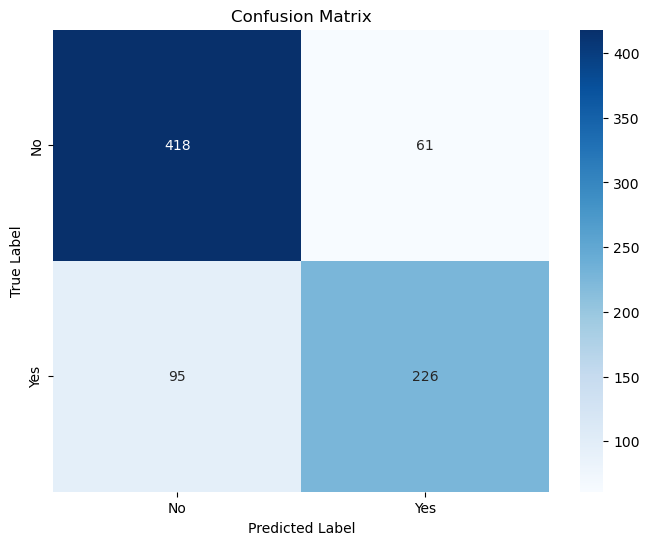

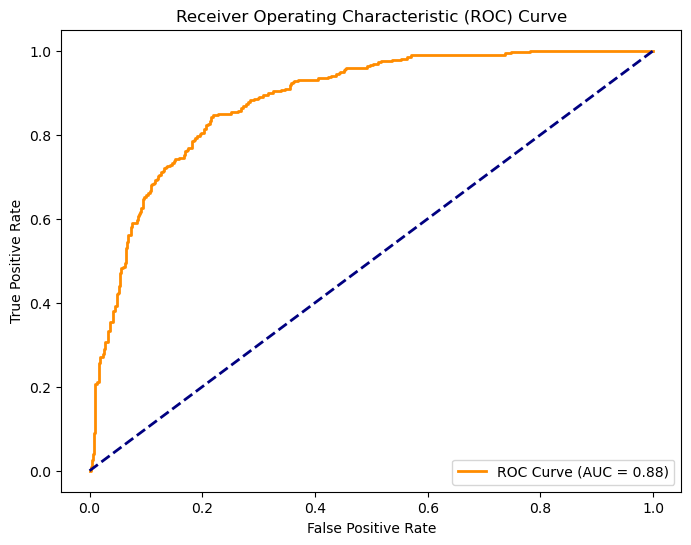

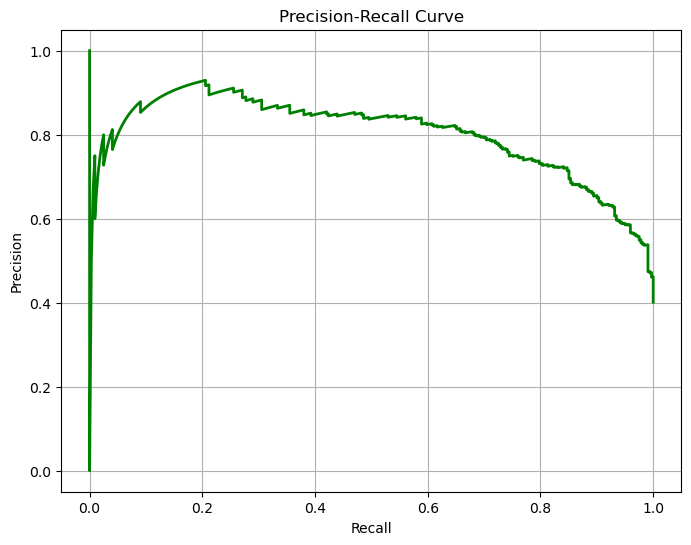

In [41]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid()
plt.show()
